In [24]:
# Standard libraries
import os 
import numpy as np  
import pandas as pd  

# Transformers library for working with pretrained models
from transformers import AutoTokenizer, AutoModel 

# PyTorch libraries for building and training models
import torch  
import torch.nn as nn  
import torch.nn.functional as F  

# PyTorch DataLoader for managing batches and loading data
from torch.utils.data import DataLoader, TensorDataset  

# Scikit-learn for model evaluation and data handling utilities
from sklearn.model_selection import train_test_split  
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, cohen_kappa_score  
from sklearn.preprocessing import LabelEncoder  
from sklearn.utils.class_weight import compute_class_weight

# Gensim for word embedding models
from gensim.models import KeyedVectors  # Load and handle word embeddings, e.g., GloVe or FastText

# Custom modules
from albert import * 

# Additional mathematical functions
import math  

# Imbalanced-learn for oversampling
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Constants
BASE_DIR = '../'  # Base directory, set to one level up to access files and directories outside of current folder
DATASET_DIR = os.path.join(BASE_DIR, 'dataset')  # Directory path to store or load dataset files
SAVE_DIR = os.path.join(BASE_DIR, 'result')  # Directory path to save model results and outputs
MODEL_NAME = "albert-base-v2"  # Pre-trained ALBERT model name for loading via Hugging Face's Transformers
GLOVE_PATH = os.path.join(BASE_DIR, 'word_embeddings/glove.6B.300d.txt')  # Path to GloVe embeddings
FASTTEXT_PATH = os.path.join(BASE_DIR, 'word_embeddings/wiki.en.vec')  # Path to FastText embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check for CUDA (GPU) availability, else use CPU

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)  # Initialize tokenizer for ALBERT model
albert_model = AutoModel.from_pretrained(MODEL_NAME).to(device)  # Load ALBERT model and move to the correct device

# List of directories to check or create if they don’t exist
directories = [BASE_DIR, DATASET_DIR, SAVE_DIR, os.path.dirname(GLOVE_PATH), os.path.dirname(FASTTEXT_PATH)]

# Check each directory in the list and create it if it doesn't already exist
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)  # Create the directory if it doesn't exist
        print(f"Directory created: {directory}")  # Log directory creation
    else:
        print(f"Directory already exists: {directory}")  # Log if directory already exists

Directory already exists: ../
Directory already exists: ../dataset
Directory already exists: ../result
Directory already exists: ../word_embeddings
Directory already exists: ../word_embeddings


In [3]:
# Load embeddings
glove_model = load_glove_model(GLOVE_PATH)  # Load GloVe embeddings from the specified file path
fasttext_model = load_fasttext_model(FASTTEXT_PATH)  # Load FastText embeddings from the specified file path

In [4]:
# Load and preprocess the dataset
df = pd.read_csv('processed_essay_dataset.csv', sep=',', encoding='ISO-8859-1')  # Load dataset from CSV file
df = df.dropna(subset=['normalized_score'])  # Drop rows where 'normalized_score' column has missing values
df.fillna(0, inplace=True)  # Fill any remaining NaN values in the dataframe with 0

In [5]:
# Define quartiles for 'normalized_score' to categorize quality labels
q1, q3 = df['normalized_score'].quantile([0.25, 0.75])  # Calculate first and third quartiles for 'normalized_score'
df['quality_label'] = pd.cut(df['normalized_score'], bins=[-1, q1, q3, 100], labels=[0, 1, 2]).astype(int)  # Categorize into labels
df['quality_label'] = df['quality_label'].map({0: 0, 1: 1, 2: 2})  # Map quality labels to 0, 1, and 2

# Map essay types to numerical values
df['essay_type'] = df['essay_type'].map({'argumentative': 0, 'dependent': 1, 'narrative': 2})  # Map essay types to integers

# Filter the dataframe to include only rows where 'essay_type' is either 0 or 1 (argumentative or dependent essays)
df = df[df['essay_type'].isin([0, 1])]

In [7]:
# Define attributes for which we want to capture min and max values
attributes = ['content', 'organization', 'word_choice', 'sentence_fluency', 'conventions', 'language', 'prompt_adherence', 'narrativity']

# Initialize dictionary to store min and max values for each attribute
attribute_ranges = {}

# Retrieve and store the min and max ranges for each attribute
for attribute in attributes:
    min_val, max_val = get_attribute_range(df, attribute)  # Get min and max values for the current attribute
    attribute_ranges[attribute] = (min_val, max_val)  # Store the range in attribute_ranges dictionary

# Print the ranges for each attribute
print("Attribute Ranges:")
for attribute, (min_val, max_val) in attribute_ranges.items():
    print(f"{attribute}: {min_val} to {max_val}")  # Print the min and max values for each attribute

Attribute Ranges:
content: 0.0 to 6.0
organization: 0.0 to 6.0
word_choice: 0.0 to 6.0
sentence_fluency: 0.0 to 6.0
conventions: 0.0 to 6.0
language: 0.0 to 4.0
prompt_adherence: 0.0 to 4.0
narrativity: 0.0 to 4.0


In [26]:
# Validate that 'quality_label' contains only the expected values: 0, 1, or 2
assert all(df['quality_label'].isin([0, 1, 2])), "Invalid quality labels!"

# Validate that 'essay_type' contains only the expected values: 0, 1, or 2
assert all(df['essay_type'].isin([0, 1, 2])), "Invalid essay type labels!"

In [27]:
# Check for NaN or Infinite values in the numeric columns
numeric_df = df.select_dtypes(include=[np.number])  # Only select numeric columns

# Check for NaN values
if numeric_df.isna().any().any():
    print("Data contains NaN values!")

# Check for infinite values
if np.isinf(numeric_df.values).any():
    print("Data contains Infinite values!")

In [28]:
attribute_ranges = {attr: get_attribute_range(df, attr) for attr in attributes}

# Compute class weights for quality_label and essay_type
quality_classes = np.array([0, 1, 2])
essay_type_classes = np.array([0, 1])

quality_class_weights = compute_class_weight(class_weight='balanced', classes=quality_classes, y=df['quality_label'])
essay_type_class_weights = compute_class_weight(class_weight='balanced', classes=essay_type_classes, y=df['essay_type'])

quality_class_weights = torch.tensor(quality_class_weights, dtype=torch.float32).to(device)
essay_type_class_weights = torch.tensor(essay_type_class_weights, dtype=torch.float32).to(device)

# Define weighted loss functions
quality_loss_fn = nn.CrossEntropyLoss(weight=quality_class_weights)
essay_type_loss_fn = nn.CrossEntropyLoss(weight=essay_type_class_weights)

In [29]:
quality_class_weights

tensor([0.9835, 0.7771, 1.4361], device='cuda:0')


Training model for embedding type: albert


/home/salsabila.pranida/.conda/envs/ai_aes/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Total Epoch Loss: 573.7722
Epoch 2/10, Total Epoch Loss: 171.5661
Epoch 3/10, Total Epoch Loss: 142.9908
Epoch 4/10, Total Epoch Loss: 131.4389
Epoch 5/10, Total Epoch Loss: 119.9870
Epoch 6/10, Total Epoch Loss: 116.8063
Epoch 7/10, Total Epoch Loss: 110.7814
Epoch 8/10, Total Epoch Loss: 114.3089
Epoch 9/10, Total Epoch Loss: 109.2900
Epoch 10/10, Total Epoch Loss: 107.5349


/home/salsabila.pranida/ai_project_aes/albert_ira/albert.py:478: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


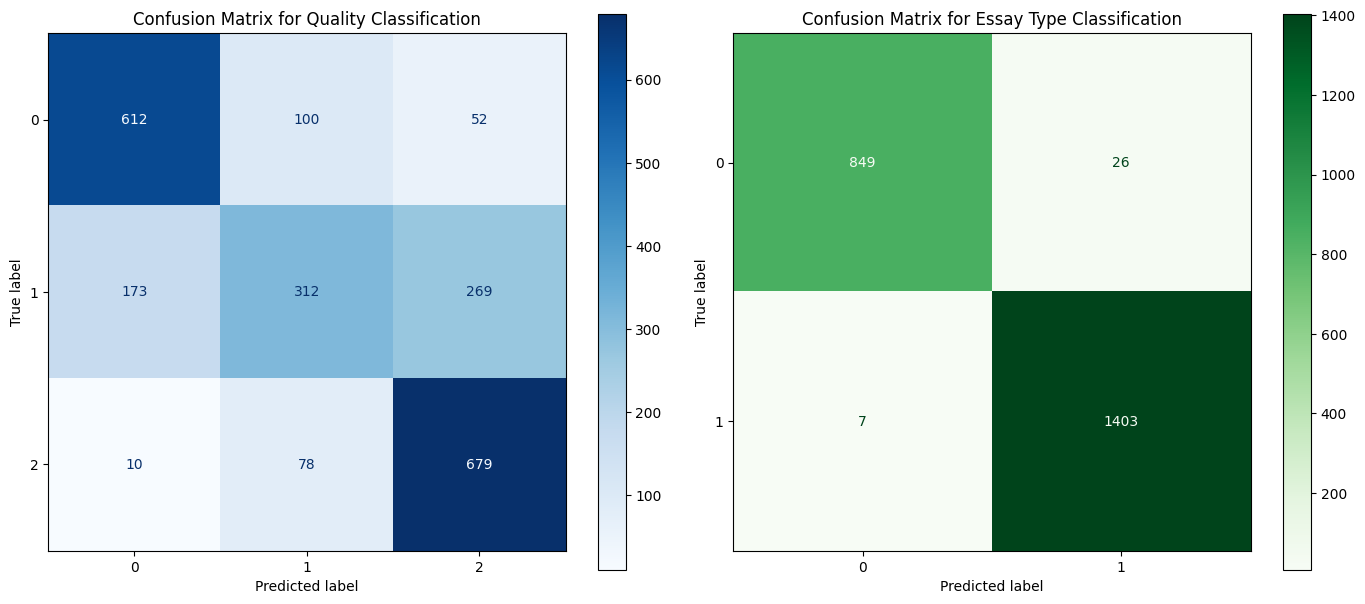

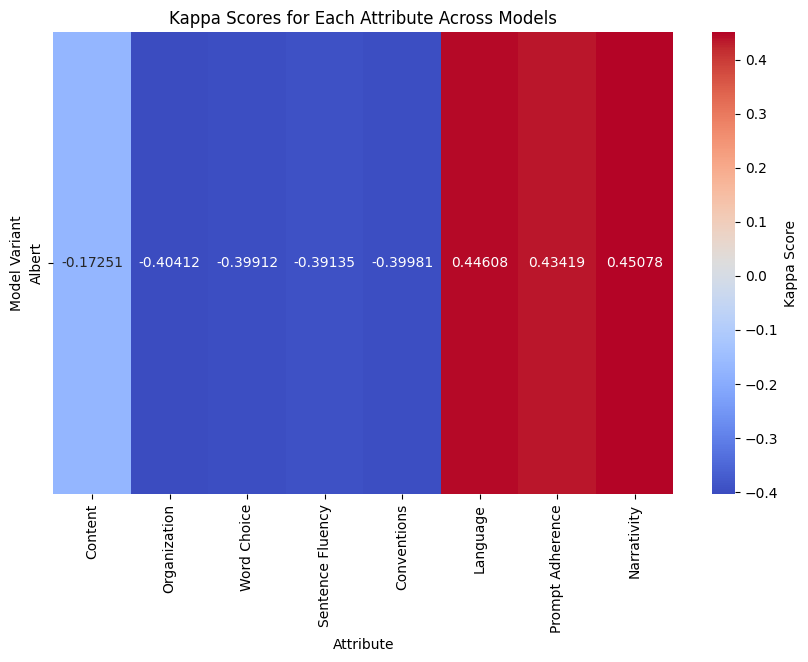

Evaluation Results: 
MSE for Score: 234.36795043945312
Quality Classification Accuracy: 0.70153
Quality Classification F1 Score: 0.68600
Quality Classification Quadratic Kappa: 0.73898
Essay Type Classification Accuracy: 0.98556
Essay Type Classification F1 Score: 0.98553
Essay Type Classification Quadratic Kappa: 0.96931
Kappa for Content: -0.17251
Kappa for Organization: -0.40412
Kappa for Word Choice: -0.39912
Kappa for Sentence Fluency: -0.39135
Kappa for Conventions: -0.39981
Kappa for Language: 0.44608
Kappa for Prompt Adherence: 0.43419
Kappa for Narrativity: 0.45078

Training model for embedding type: glove


/home/salsabila.pranida/.conda/envs/ai_aes/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Total Epoch Loss: 570.1532
Epoch 2/10, Total Epoch Loss: 169.3978
Epoch 3/10, Total Epoch Loss: 142.8384
Epoch 4/10, Total Epoch Loss: 127.3324
Epoch 5/10, Total Epoch Loss: 122.1376
Epoch 6/10, Total Epoch Loss: 115.0624
Epoch 7/10, Total Epoch Loss: 112.4269
Epoch 8/10, Total Epoch Loss: 109.0107
Epoch 9/10, Total Epoch Loss: 108.2362
Epoch 10/10, Total Epoch Loss: 108.8345


/home/salsabila.pranida/ai_project_aes/albert_ira/albert.py:478: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


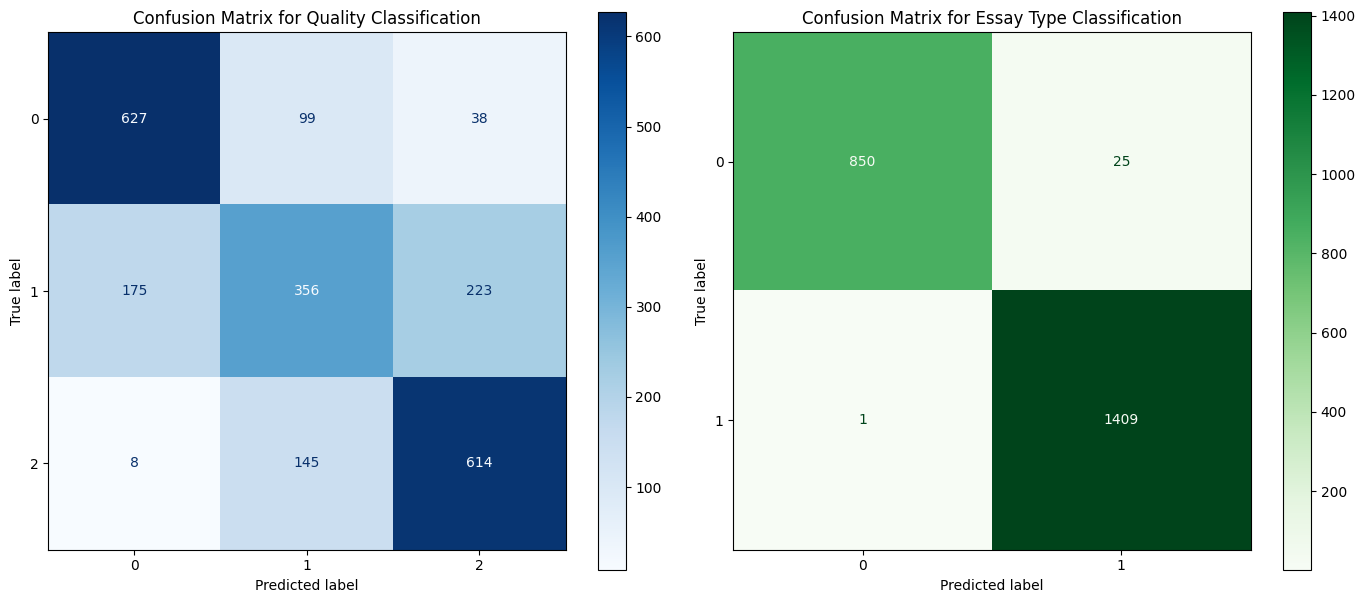

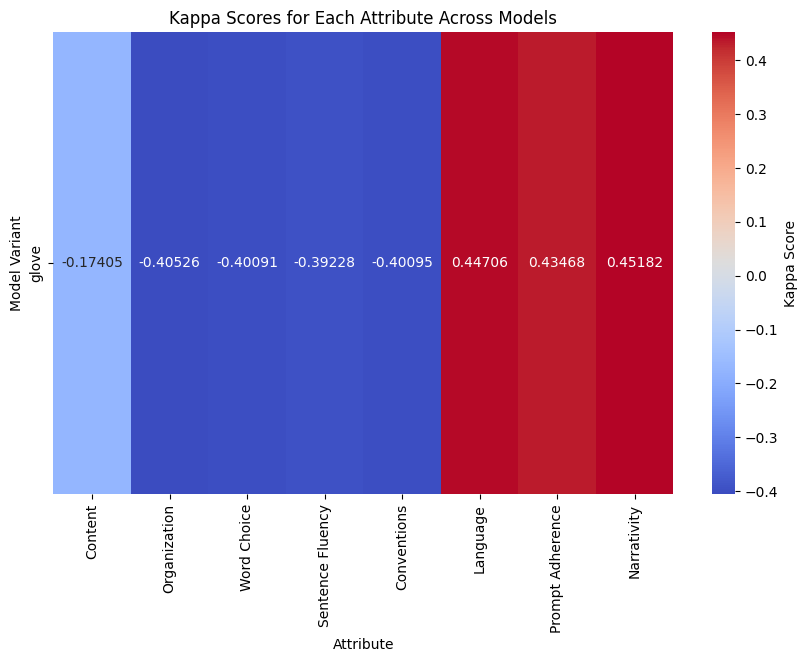

Evaluation Results: 
MSE for Score: 231.79928588867188
Quality Classification Accuracy: 0.69891
Quality Classification F1 Score: 0.69093
Quality Classification Quadratic Kappa: 0.74315
Essay Type Classification Accuracy: 0.98862
Essay Type Classification F1 Score: 0.98859
Essay Type Classification Quadratic Kappa: 0.97580
Kappa for Content: -0.17405
Kappa for Organization: -0.40526
Kappa for Word Choice: -0.40091
Kappa for Sentence Fluency: -0.39228
Kappa for Conventions: -0.40095
Kappa for Language: 0.44706
Kappa for Prompt Adherence: 0.43468
Kappa for Narrativity: 0.45182

Training model for embedding type: fasttext


/home/salsabila.pranida/.conda/envs/ai_aes/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Total Epoch Loss: 569.5709
Epoch 2/10, Total Epoch Loss: 168.5265
Epoch 3/10, Total Epoch Loss: 145.0642
Epoch 4/10, Total Epoch Loss: 128.2125
Epoch 5/10, Total Epoch Loss: 122.2719
Epoch 6/10, Total Epoch Loss: 116.9745
Epoch 7/10, Total Epoch Loss: 114.2562
Epoch 8/10, Total Epoch Loss: 111.6598
Epoch 9/10, Total Epoch Loss: 110.2531
Epoch 10/10, Total Epoch Loss: 107.3846


/home/salsabila.pranida/ai_project_aes/albert_ira/albert.py:478: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


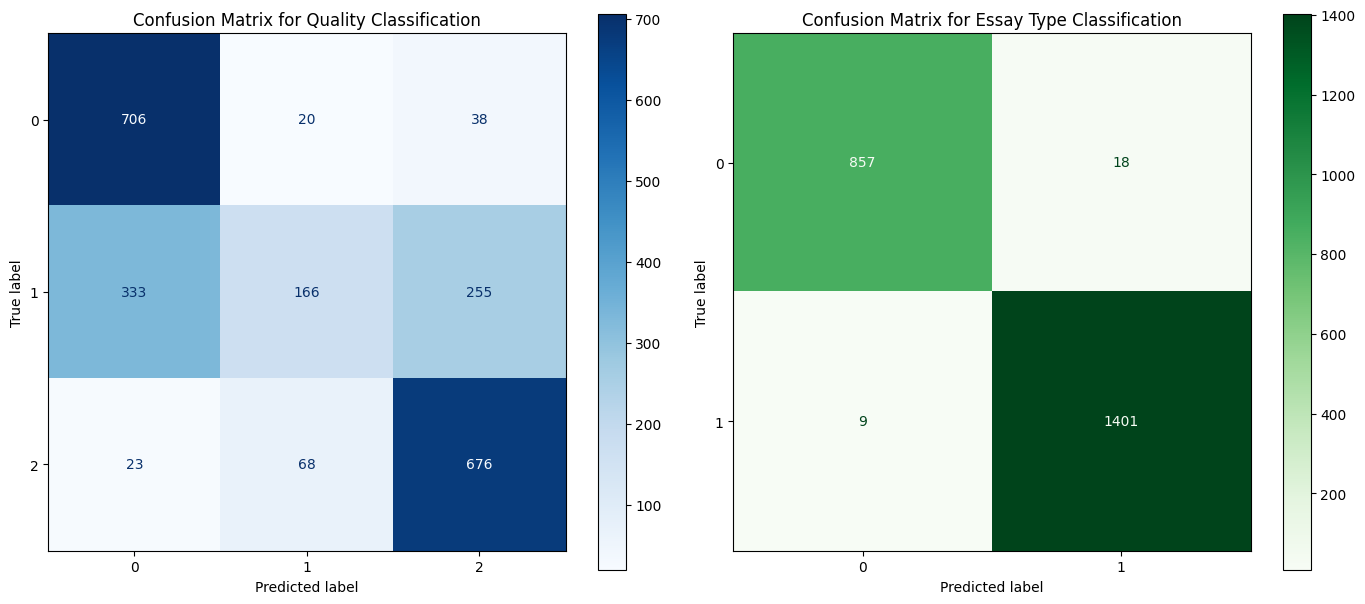

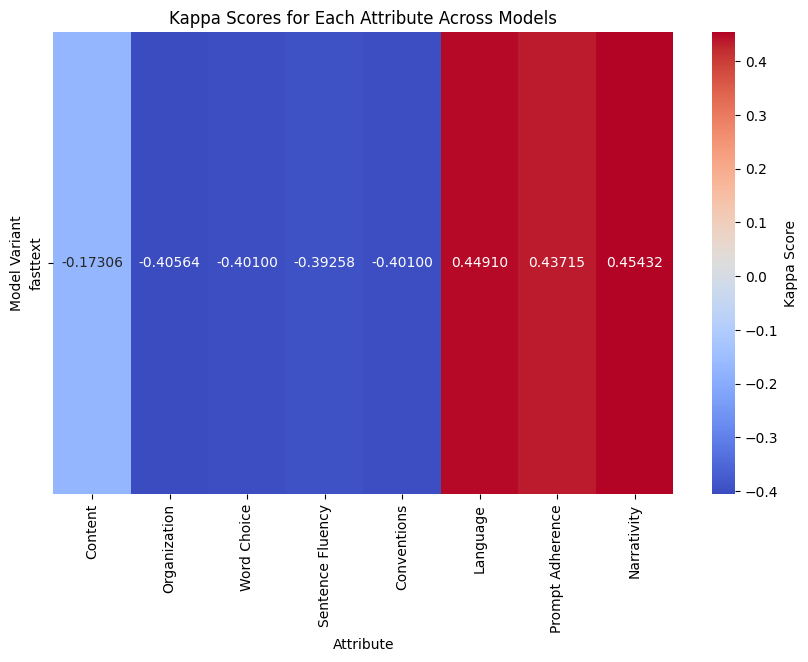

Evaluation Results: 
MSE for Score: 234.785888671875
Quality Classification Accuracy: 0.67746
Quality Classification F1 Score: 0.62865
Quality Classification Quadratic Kappa: 0.74174
Essay Type Classification Accuracy: 0.98818
Essay Type Classification F1 Score: 0.98817
Essay Type Classification Quadratic Kappa: 0.97495
Kappa for Content: -0.17306
Kappa for Organization: -0.40564
Kappa for Word Choice: -0.40100
Kappa for Sentence Fluency: -0.39258
Kappa for Conventions: -0.40100
Kappa for Language: 0.44910
Kappa for Prompt Adherence: 0.43715
Kappa for Narrativity: 0.45432


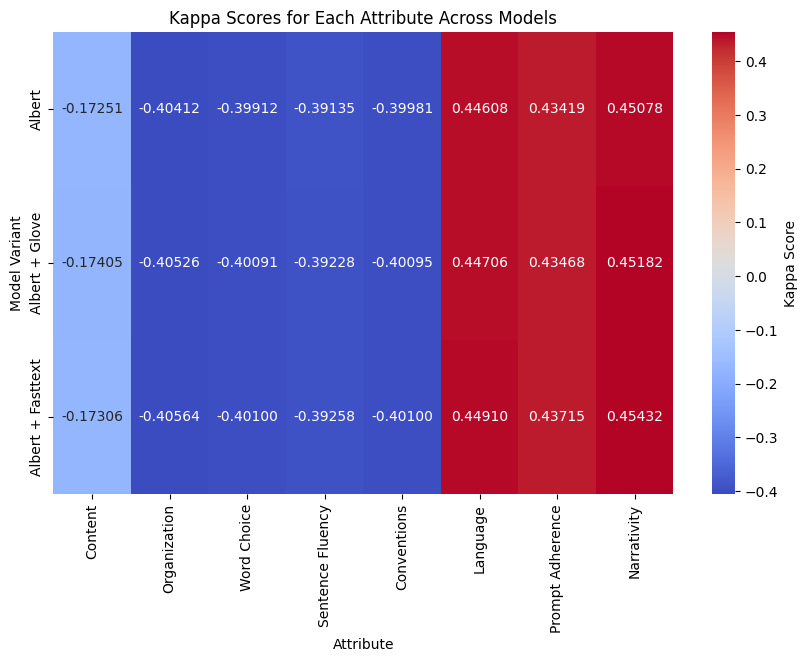

In [36]:
# Define embedding types to experiment with: ALBERT-only, ALBERT + GloVe, and ALBERT + FastText
embedding_types = [None, "glove", "fasttext"]
all_kappa_scores = []  # List to store Kappa scores for all attribute evaluations across models

for embedding_type in embedding_types:
    # Set the model name based on embedding type for easier tracking
    model_name = embedding_type if embedding_type else 'Albert'

    # Generate embeddings for each essay text, optionally combining ALBERT with GloVe or FastText embeddings
    embeddings_and_sizes = df['essay'].apply(lambda x: create_combined_embedding(x, embedding_type, glove_model, fasttext_model))

    # Unpack the combined embedding data (embedding vector and its size) for each essay
    df['embeddings'], embedding_sizes = zip(*embeddings_and_sizes)

    # Convert embedding sizes to numpy array to track embedding dimensions later if needed
    embedding_sizes = np.array(embedding_sizes)

    # Combine all relevant features and labels into one DataFrame for resampling
    combined_df = pd.DataFrame({
        'embeddings': list(df['embeddings']),
        'normalized_score': df['normalized_score'],  # Adding primary regression target
        'quality_label': df['quality_label'],
        'essay_type': df['essay_type'],
        'content': df['content'],
        'organization': df['organization'],
        'word_choice': df['word_choice'],
        'sentence_fluency': df['sentence_fluency'],
        'conventions': df['conventions'],
        'language': df['language'],
        'prompt_adherence': df['prompt_adherence'],
        'narrativity': df['narrativity']
    })

    # Apply RandomOverSampler on the combined data
    ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
    resampled_data, _ = ros.fit_resample(combined_df, df['quality_label'])

    # Separate resampled data back into individual components
    X_resampled = np.stack(resampled_data['embeddings'])
    y_resampled = resampled_data['normalized_score'].values  # Primary regression target
    y_quality_resampled = resampled_data['quality_label'].values
    y_essay_type_resampled = resampled_data['essay_type'].values
    y_content_resampled = resampled_data['content'].values
    y_organization_resampled = resampled_data['organization'].values
    y_word_choice_resampled = resampled_data['word_choice'].values
    y_sentence_fluency_resampled = resampled_data['sentence_fluency'].values
    y_conventions_resampled = resampled_data['conventions'].values
    y_language_resampled = resampled_data['language'].values
    y_prompt_adherence_resampled = resampled_data['prompt_adherence'].values
    y_narrativity_resampled = resampled_data['narrativity'].values

    # Split the resampled data into training and testing sets
    (
        X_train, X_test, y_train, y_test, y_train_quality, y_test_quality, y_train_essay_type, y_test_essay_type, 
        y_train_content, y_test_content, y_train_organization, y_test_organization,
        y_train_word_choice, y_test_word_choice, y_train_sentence_fluency, y_test_sentence_fluency, 
        y_train_conventions, y_test_conventions, y_train_language, y_test_language, 
        y_train_prompt_adherence, y_test_prompt_adherence, y_train_narrativity, y_test_narrativity
    ) = train_test_split(
        X_resampled, 
        y_resampled,
        y_quality_resampled,
        y_essay_type_resampled,
        y_content_resampled,
        y_organization_resampled,
        y_word_choice_resampled,
        y_sentence_fluency_resampled,
        y_conventions_resampled,
        y_language_resampled,
        y_prompt_adherence_resampled,
        y_narrativity_resampled,
        test_size=0.2,
        random_state=42
    )

    # Convert each subset to PyTorch tensors for compatibility with the training process
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Reshape for regression target
    y_train_quality_tensor = torch.tensor(y_train_quality, dtype=torch.long)
    y_train_essay_type_tensor = torch.tensor(y_train_essay_type, dtype=torch.long)
    y_train_content_tensor = torch.tensor(y_train_content, dtype=torch.float32)
    y_train_organization_tensor = torch.tensor(y_train_organization, dtype=torch.float32)
    y_train_word_choice_tensor = torch.tensor(y_train_word_choice, dtype=torch.float32)
    y_train_sentence_fluency_tensor = torch.tensor(y_train_sentence_fluency, dtype=torch.float32)
    y_train_conventions_tensor = torch.tensor(y_train_conventions, dtype=torch.float32)
    y_train_language_tensor = torch.tensor(y_train_language, dtype=torch.float32)
    y_train_prompt_adherence_tensor = torch.tensor(y_train_prompt_adherence, dtype=torch.float32)
    y_train_narrativity_tensor = torch.tensor(y_train_narrativity, dtype=torch.float32)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    y_test_quality_tensor = torch.tensor(y_test_quality, dtype=torch.long)
    y_test_essay_type_tensor = torch.tensor(y_test_essay_type, dtype=torch.long)
    y_test_content_tensor = torch.tensor(y_test_content, dtype=torch.float32)
    y_test_organization_tensor = torch.tensor(y_test_organization, dtype=torch.float32)
    y_test_word_choice_tensor = torch.tensor(y_test_word_choice, dtype=torch.float32)
    y_test_sentence_fluency_tensor = torch.tensor(y_test_sentence_fluency, dtype=torch.float32)
    y_test_conventions_tensor = torch.tensor(y_test_conventions, dtype=torch.float32)
    y_test_language_tensor = torch.tensor(y_test_language, dtype=torch.float32)
    y_test_prompt_adherence_tensor = torch.tensor(y_test_prompt_adherence, dtype=torch.float32)
    y_test_narrativity_tensor = torch.tensor(y_test_narrativity, dtype=torch.float32)

    # Train the model with the current embedding type and save it for future evaluation
    print(f"\nTraining model for embedding type: {embedding_type or 'albert'}")
    model_path = train_and_save_model(
        X_train_tensor,
        y_train_tensor,  # Primary regression target (assuming this is for `normalized_score`)
        y_train_quality_tensor,
        y_train_essay_type_tensor,
        y_train_content_tensor,
        y_train_organization_tensor,
        y_train_word_choice_tensor,
        y_train_sentence_fluency_tensor,
        y_train_conventions_tensor,
        y_train_language_tensor,
        y_train_prompt_adherence_tensor,
        y_train_narrativity_tensor,  
        input_shape=X_train_tensor.shape[1],  # Ensure `input_shape` is passed correctly
        save_dir=SAVE_DIR,
        embedding_type=embedding_type,
        epochs=10,
        batch_size=8,
        learning_rate=1e-3
    )

    # Evaluate the trained model and collect metrics, particularly Kappa scores for each attribute
    mse, accuracy_quality, f1_quality, kappa_quality, accuracy_essay_type, f1_essay_type, kappa_essay_type, \
    kappa_content, kappa_organization, kappa_word_choice, kappa_sentence_fluency, kappa_conventions, \
    kappa_language, kappa_prompt_adherence, kappa_narrativity = evaluate_model(
        model_path, X_test_tensor, y_test_tensor.squeeze().numpy(), y_test_quality_tensor, y_test_essay_type_tensor,
        y_test_content_tensor, y_test_organization_tensor, y_test_word_choice_tensor, 
        y_test_sentence_fluency_tensor, y_test_conventions_tensor, y_test_language_tensor, y_test_prompt_adherence_tensor, 
        y_test_narrativity_tensor, SAVE_DIR, model_name
    )

    # Append Kappa scores for each attribute to all_kappa_scores to plot later
    all_kappa_scores.append([kappa_content, kappa_organization, kappa_word_choice, kappa_sentence_fluency, \
        kappa_conventions, kappa_language, kappa_prompt_adherence, kappa_narrativity])

# Plot a heatmap of Kappa scores for each model variant to visualize attribute-level performance
plot_kappa_heatmap(
    all_kappa_scores,
    model_names=['Albert', 'Albert + Glove', 'Albert + Fasttext'],
    attribute_names=[
        'Content', 'Organization', 'Word Choice', 'Sentence Fluency',
        'Conventions', 'Language', 'Prompt Adherence', 'Narrativity'
    ]
)

In [11]:
content = """
    In “Let there be dark,” Paul Bogard talks about the importance of darkness.
Darkness is essential to humans. Bogard states, “Our bodies need darkness to produce the hormone melatonin, which keeps certain cancers from developing, and our bodies need darkness for sleep, sleep. Sleep disorders have been linked to diabetes, obesity, cardiovascular disease and depression and recent research suggests are main cause of “short sleep” is “long light.” Whether we work at night or simply take our tablets, notebooks and smartphones to bed, there isn’t a place for this much artificial light in our lives.” (Bogard 2). Here, Bogard talks about the importance of darkness to humans. Humans need darkness to sleep in order to be healthy.
Animals also need darkness. Bogard states, “The rest of the world depends on darkness as well, including nocturnal and crepuscular species of birds, insects, mammals, fish and reptiles. Some examples are well known—the 400 species of birds that migrate at night in North America, the sea turtles that come ashore to lay their eggs—and some are not, such as the bats that save American farmers billions in pest control and the moths that pollinate 80% of the world’s flora. Ecological light pollution is like the bulldozer of the night, wrecking habitat and disrupting ecosystems several billion years in the making. Simply put, without darkness, Earth’s ecology would collapse...” (Bogard 2). Here Bogard explains that animals, too, need darkness to survive.
""" 

In [12]:
results = {}
embedding_types = [None, "glove", "fasttext"]

for embedding_type in embedding_types:
    if embedding_type is None:
        embedding_type_name = "ALBERT"
    elif embedding_type == "glove":
        embedding_type_name = "ALBERT + GloVe"
    elif embedding_type == "fasttext":
        embedding_type_name = "ALBERT + FastText"

    score, quality_label, essay_type, content, organization, word_choice, sentence_fluency, conventions = testContent(
            content, 
            embedding_type=embedding_type, 
            SAVE_DIR=SAVE_DIR, 
            glove_model=glove_model, 
            fasttext_model=fasttext_model,
            attribute_ranges=attribute_ranges  # Pass attribute_ranges here
        )

    results[embedding_type_name] = {
        "score": score, 
        "quality": quality_label, 
        "essay_type": essay_type,
        "content": content, 
        "organization": organization, 
        "word_choice": word_choice, 
        "sentence_fluency": sentence_fluency,
        "conventions": conventions, 
        "language": language,
        "prompt_adherence": prompt_adherence,
        "narrativity": narrativity
    }

# Display the results
for embedding_name, result in results.items():
    print(f"Sample Essay Scores for {embedding_name}:")
    print(f"  Score: {result['score']} - Quality: {result['quality']} - Essay Type: {result['essay_type']}")
    print(f"  Content: {result['content']} - Organization: {result['organization']} - Word Choice: {result['word_choice']}")
    print(f"  Sentence Fluency: {result['sentence_fluency']} - Conventions: {result['conventions']}")
    print(f"  Language: {result['language']} - Prompt Adherence: {result['prompt_adherence']} - Narrativity: {result['narrativity']}")


/home/salsabila.pranida/ai_project_aes/albert_ira/albert.py:630: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


ValueError: too many values to unpack (expected 8)